## Analyze the whole-brain voxel-wise GLM results

The numbering of the first-level COPEs:

- 8 basic contrasts:
    1. stim_easy
    2. stim_hard
    3. cue_left
    4. cue_right
    5. cue_neutral
    6. response_left
    7. response_right
    8. error
- `cue`, `stim`, `response`:
    9. cue
    10. stim
    11. response
- The actual constrasts of interest:
    12. Cue payoff - cue neutral (= (cue_left + cue_right) - 2\*cue_neutral)
    13. stim_hard - stim_easy
    14. Response left - response right
    15. Cue left - cue right

The numbering of the third-level COPEs:
1. Intercept positive
2. Dataset
3. Covariate z_shift
4. Covariate v_shift
5. Covariate v_shift_bias
6. Intercept negative
7. Dataset negative
8. Covariate z_shift negative
9. Covariate v_shift negative
10. Covariate v_shift_bias negative

In [193]:
# Look-up dictionaries
first_level_copes = {'stim_easy': 1,
                     'stim_hard': 2,
                     'cue_left': 3,
                     'cue_right': 4,
                     'cue_neutral': 5,
                     'response_left': 6,
                     'response_right': 7,
                     'error': 8,
                     'cue': 9,
                     'stim': 10,
                     'response': 11,
                     'cue_payoff - cue_neutral': 12,
                     'stim_hard - stim_easy': 13,
                     'response_left - response_right': 14,
                     'cue_left - cue_right': 15}

second_level_copes = {'intercept': 1,
                      'dataset': 2,
                      'z_shift': 3,
                      'v_shift': 4,
                      'v_shift_bias': 5,
                      '-intercept': 6,
                      '-dataset': 7,
                      '-z_shift': 8,
                      '-v_shift': 9,
                      '-v_shift_bias': 10}

In [194]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

# t1w background image template
mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

In [196]:

def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, thresholding=None, 
                          base_dir='./derivatives/both/glm_level3'):
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]

    gfeat_dir = os.path.join(base_dir, 'cope{}.gfeat').format(cope1)
    
    if thresholding is None:
        nii = nib.load(os.path.join(gfeat_dir, 'cope1.feat', 'stats', 'zstat{}.nii.gz').format(cope2))
        threshold = 0
    elif thresholding == 'fwer' or thresholding == 'cluster':
        nii_pos = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(cope2)
        neg_contrast = cope2+5
        nii_neg = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(neg_contrast)
        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nib.load(nii_pos).get_fdata())
    elif thresholding == 'fwer1':
        # single side only
        nii = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(cope2)
        threshold = np.min(nib.load(nii).get_fdata())
        
    elif thresholding == 'fdr':
        nii = nib.load(os.path.join(gfeat_dir, 'cope1.feat', 'stats', 'zstat{}.nii.gz').format(cope2))
        _, threshold = map_threshold(nii, alpha=0.05, height_control='fdr')

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode='z', colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

# plot_4x4(z_map1, threshold=threshold, bg_img=mni09c, title='Test title')

## Contrast-of-interest 1: left_response > right_response

##### FDR thresholding

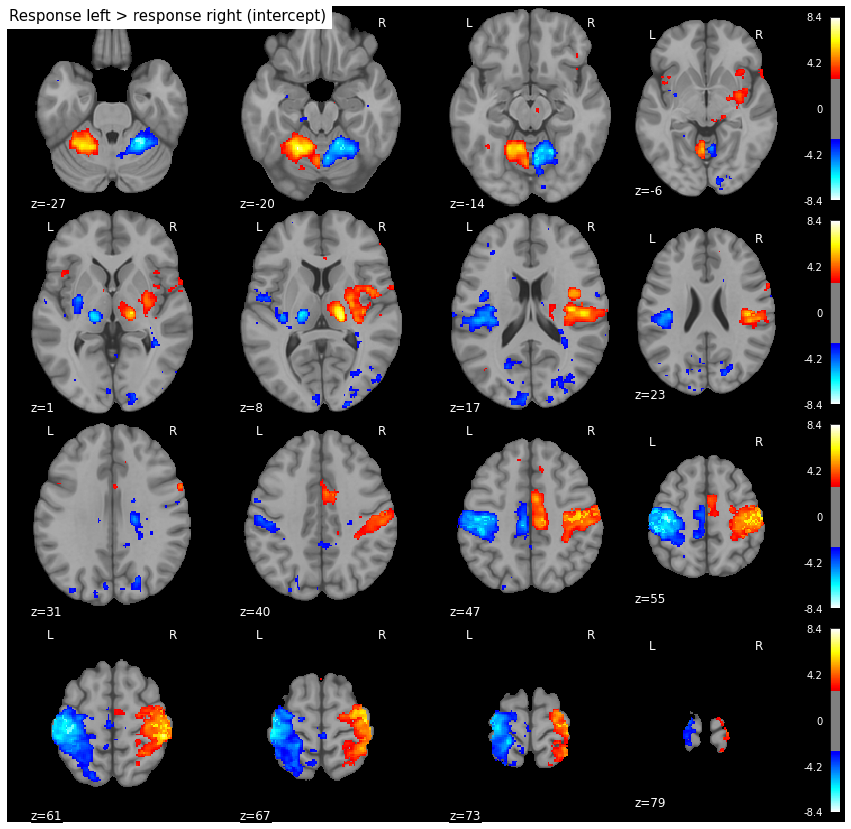

In [6]:
z_map_responselr_intercept, threshold = get_second_level_zmap('response_left - response_right', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, bg_img=mni09c, title='Response left > response right (intercept)')

##### Cluster-wise thresholding from FSL

"Significant" voxels were selected by thresholding with a z-value of 3.1 (p=0.001); then clusters were identified using a cluster-wise threshold of p=0.05

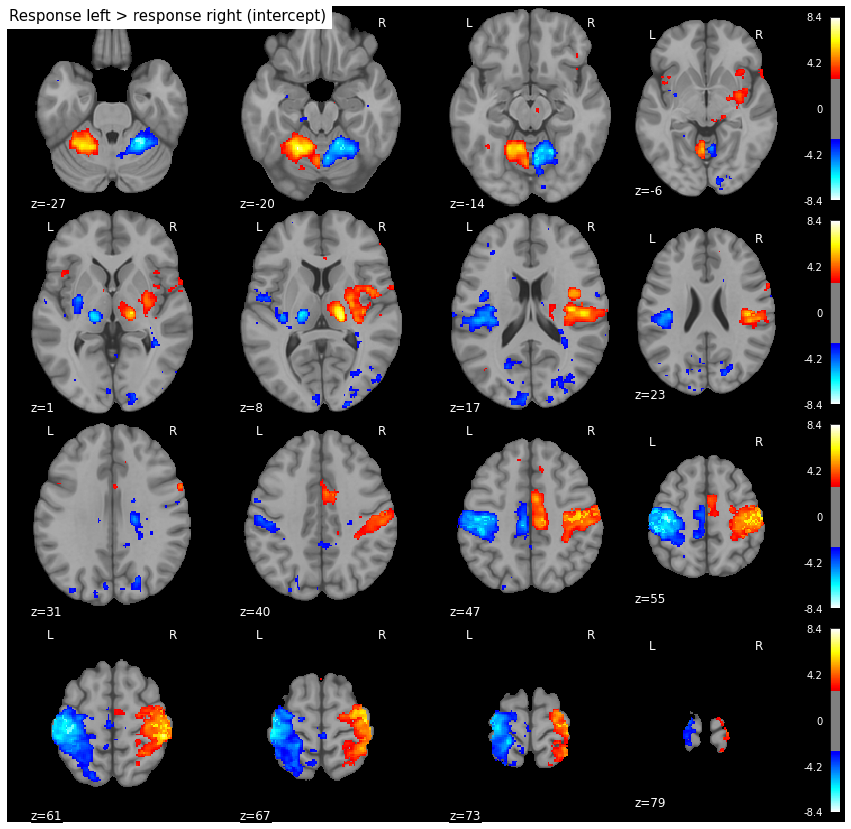

In [7]:
z_map_responselr_intercept_fwer, threshold = get_second_level_zmap('response_left - response_right', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_responselr_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Response left > response right (intercept)')

##### any difference between datasets here?

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


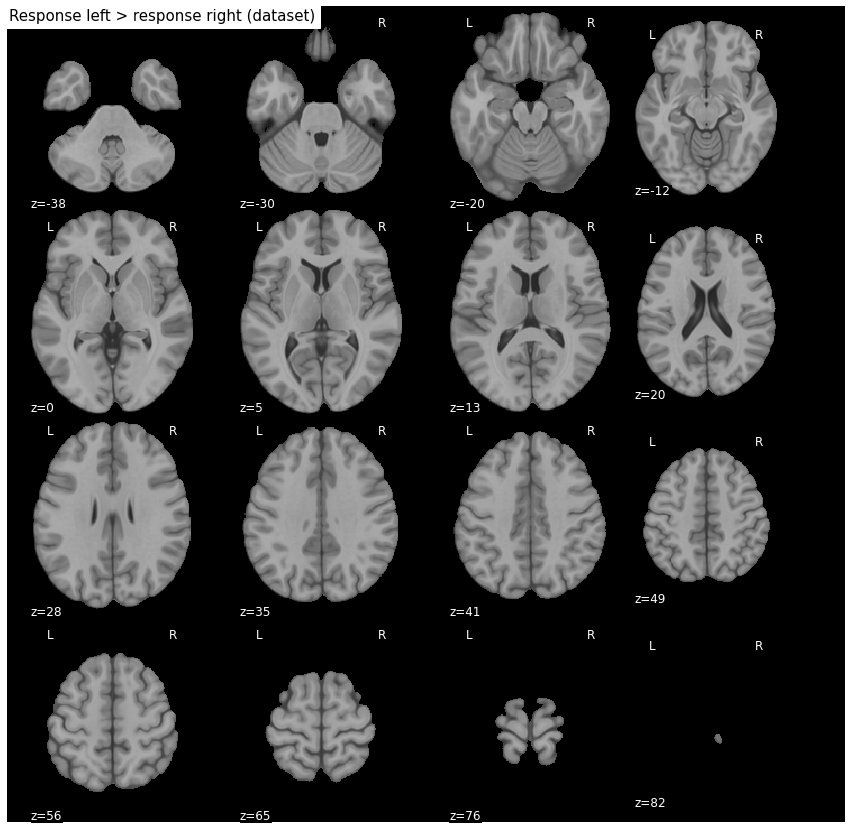

In [8]:
z_map_responselr_dataset, threshold = get_second_level_zmap('response_left - response_right', 'dataset', 'fdr')
f, ax = plot_4x4(z_map_responselr_dataset, threshold=threshold, bg_img=mni09c, title='Response left > response right (dataset)')

## 2. Effect of error

##### FDR thresholding

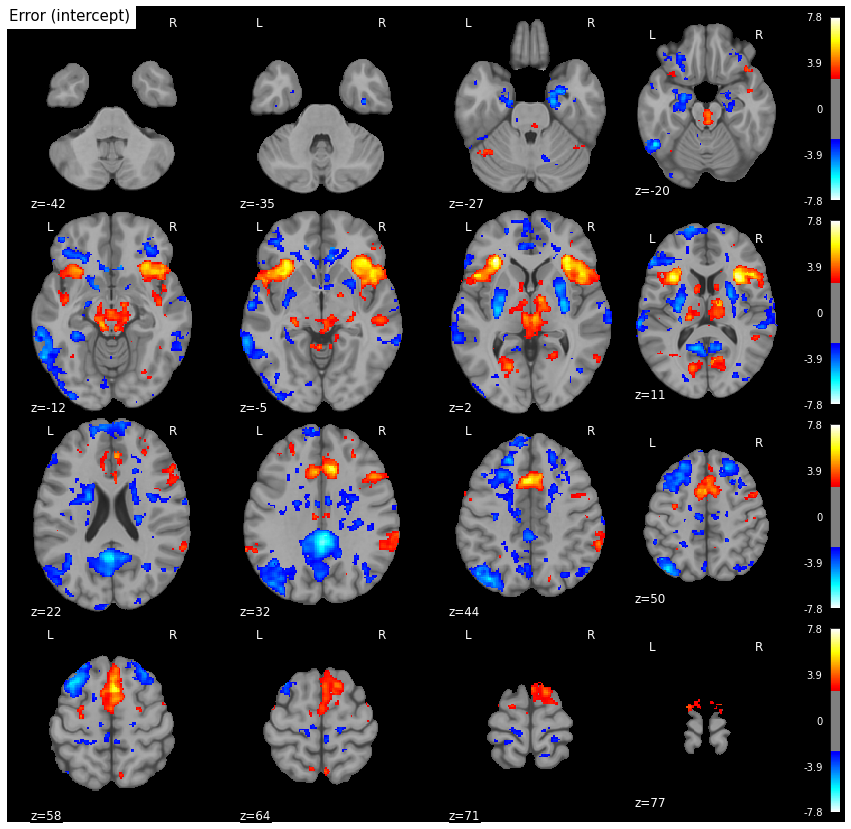

In [9]:
z_map_error_intercept, threshold = get_second_level_zmap('error', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_error_intercept, threshold=threshold, bg_img=mni09c, title='Error (intercept)')

#### FWER cluster thresholding

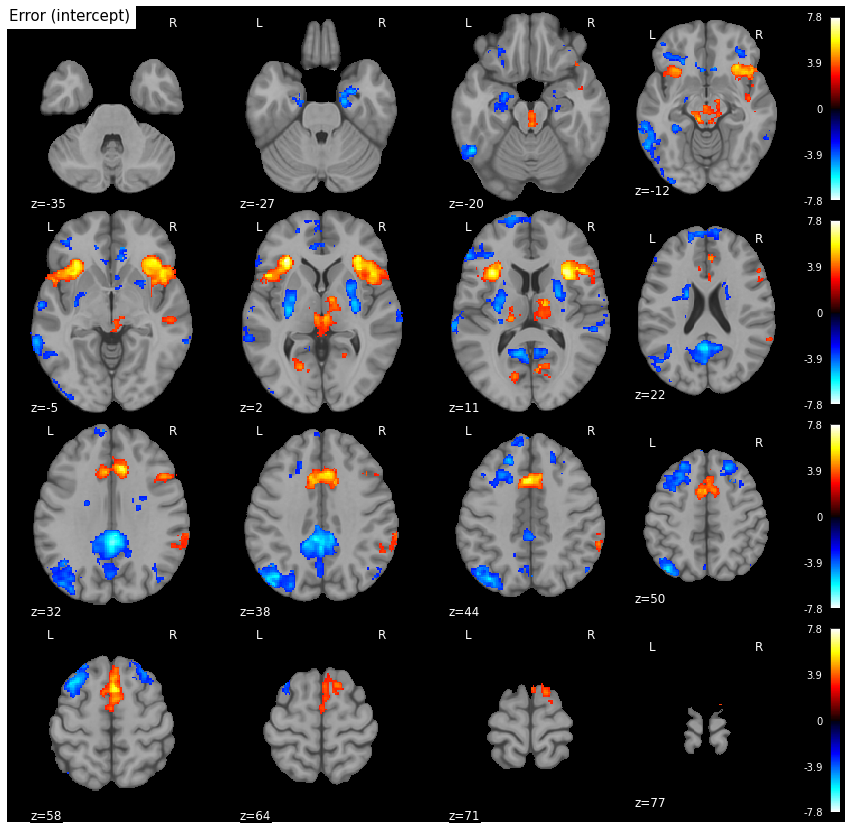

In [10]:
z_map_error_intercept_fwer, threshold = get_second_level_zmap('error', 'intercept', 'fwer')
f, ax = plot_4x4(z_map_error_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Error (intercept)')

It's a messy picture, but we see some positive clusters:
- "cognitive control"-related areas such as insula, and ACC
- prefrontal / premotor areas (preSMA? or even more frontal?) 
- Thalamus
- Some brain stem

And negative:
- Dorsal CC
- A large negative cluster in visual areas that extends quite far superior
- Putamen

## Effect of cue payoff > cue neutral

First, check against second-level intercept

####  FDR

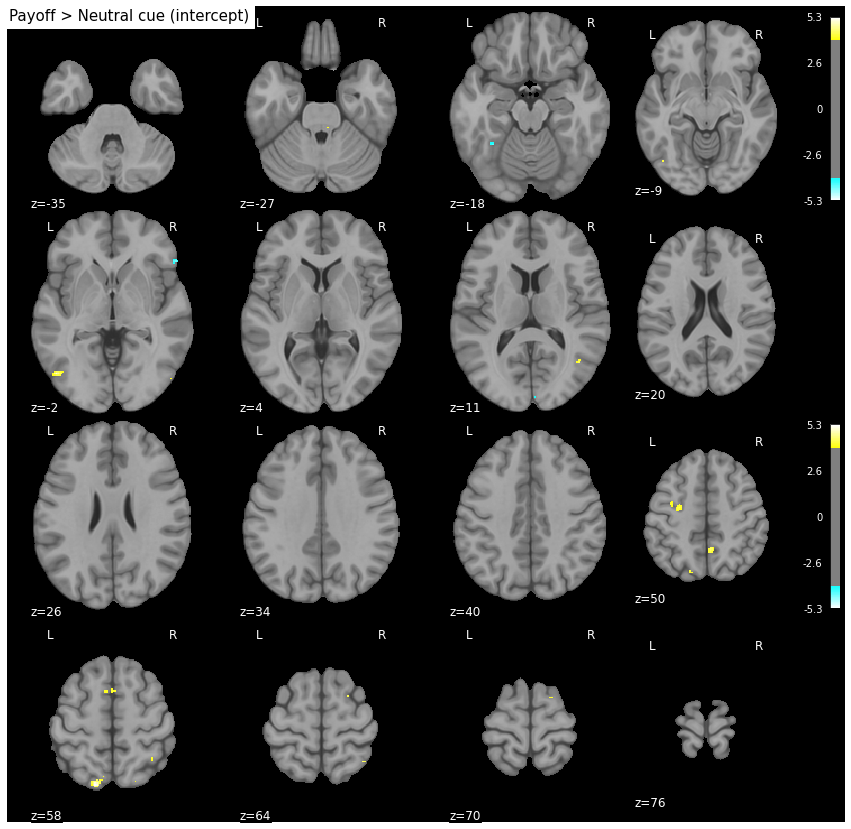

In [11]:
z_map_cue_intercept, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_cue_intercept, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (intercept)')

#### FWER cluster

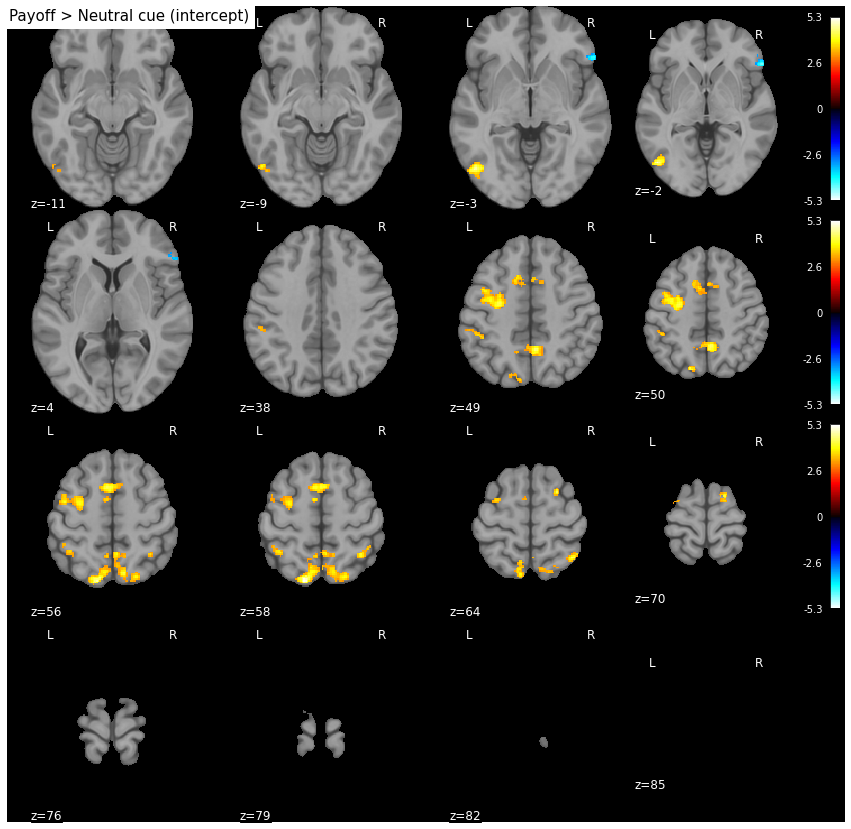

In [12]:
z_map_cue_intercept_fwer, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'intercept', 'fwer')
f, ax = plot_4x4(z_map_cue_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (intercept)')

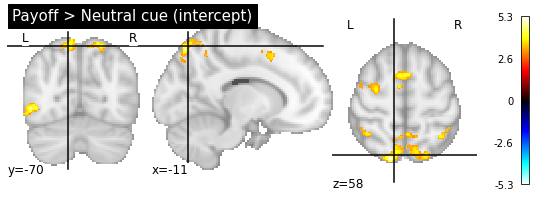

In [13]:
plotting.plot_stat_map(z_map_cue_intercept_fwer, title='Payoff > Neutral cue (intercept)')

##### So there seem to be some effects in parietal and visual cortex, and some frontal (pre-motor?) regions

### Against parametric covariates, no cluster survives

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

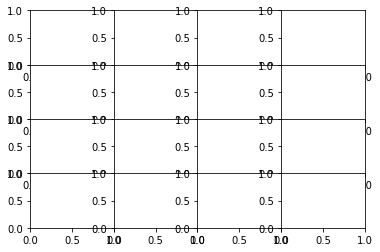

In [14]:
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'z_shift', 'fwer')
plot_4x4(z_map_cue_zshift, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (start point shift)')

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

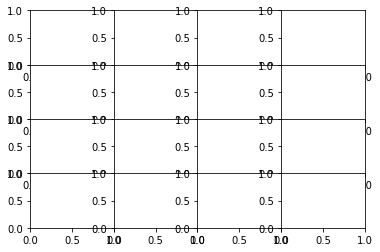

In [15]:
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'v_shift_bias', 'fwer')
plot_4x4(z_map_cue_zshift, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (drift bias shift)')

(<Figure size 1080x1080 with 35 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

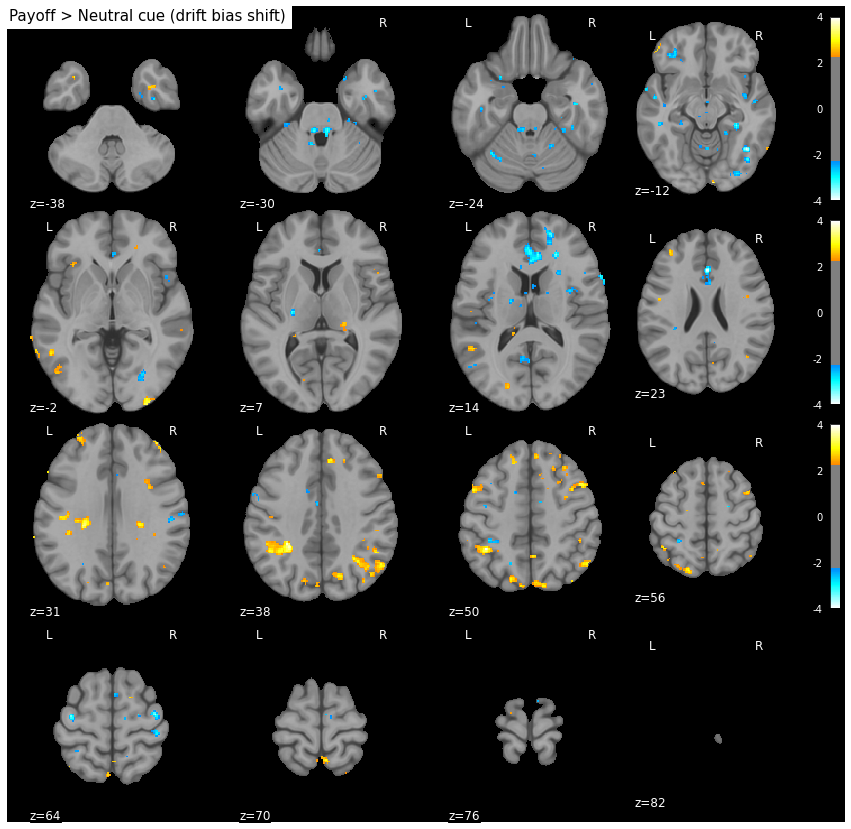

In [16]:
# Sub-threshold? e.g., z=2.3
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'v_shift_bias', None)
plot_4x4(z_map_cue_zshift, threshold=2.3, bg_img=mni09c, title='Payoff > Neutral cue (drift bias shift)')

Sub-threshold, there appears to be a parietal cluster in IPS for the covariance with *drift rate* shifts

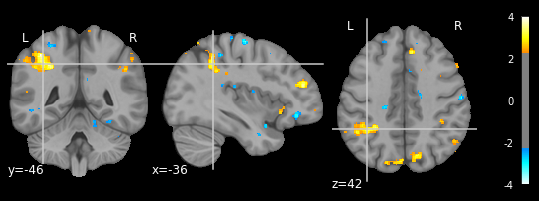

In [17]:
z_map_cue_vshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'v_shift_bias', None)
plotting.plot_stat_map(z_map_cue_vshift, threshold=2.3, bg_img=mni09c)

But not (really) with *starting point* shifts

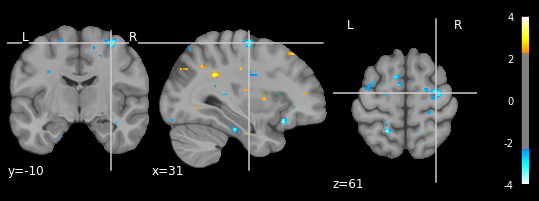

In [18]:
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'z_shift', None)
plotting.plot_stat_map(z_map_cue_zshift, threshold=2.3, bg_img=mni09c)

(<Figure size 1080x1080 with 36 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

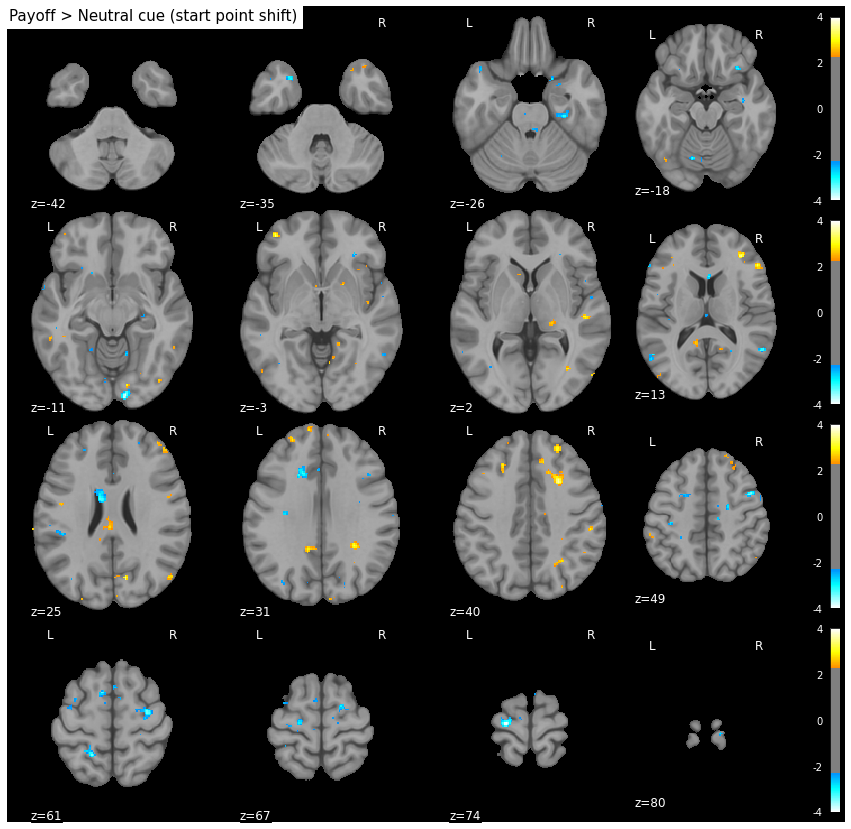

In [19]:
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'z_shift', None)
plot_4x4(z_map_cue_zshift, threshold=2.3, bg_img=mni09c, title='Payoff > Neutral cue (start point shift)')

## Hard > Easy

FDR thresholding

(<Figure size 1080x1080 with 32 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

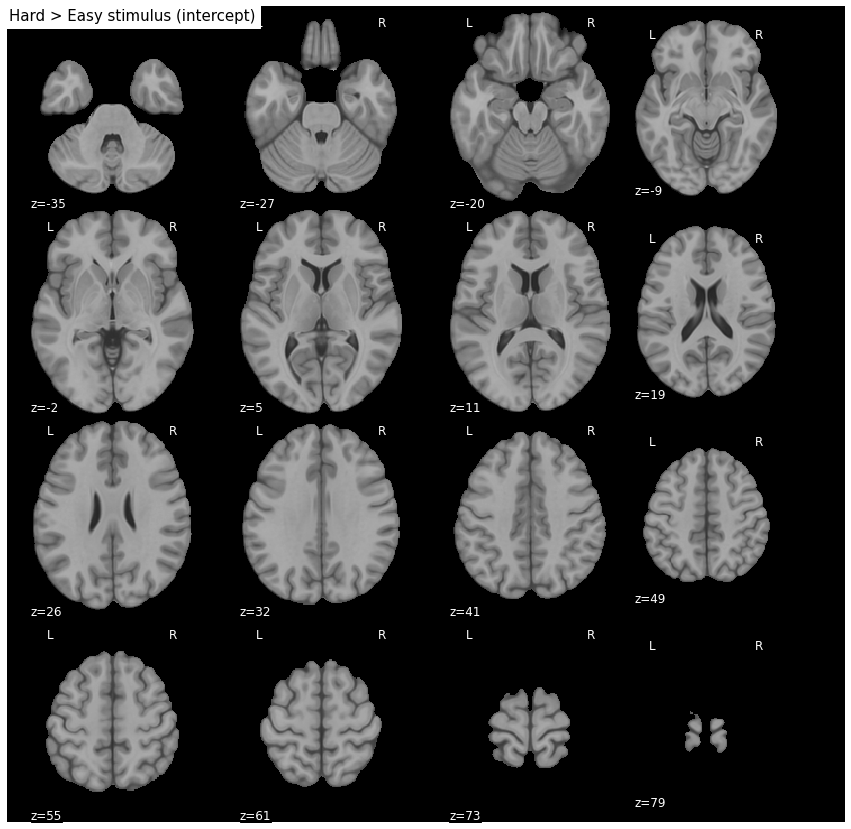

In [22]:
z_map_diff_intercept, threshold = get_second_level_zmap('stim_hard - stim_easy', 'intercept', 'fdr')
plot_4x4(z_map_diff_intercept, threshold=threshold, bg_img=mni09c, title='Hard > Easy stimulus (intercept)')

FWER thresholding

(<Figure size 1080x1080 with 36 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

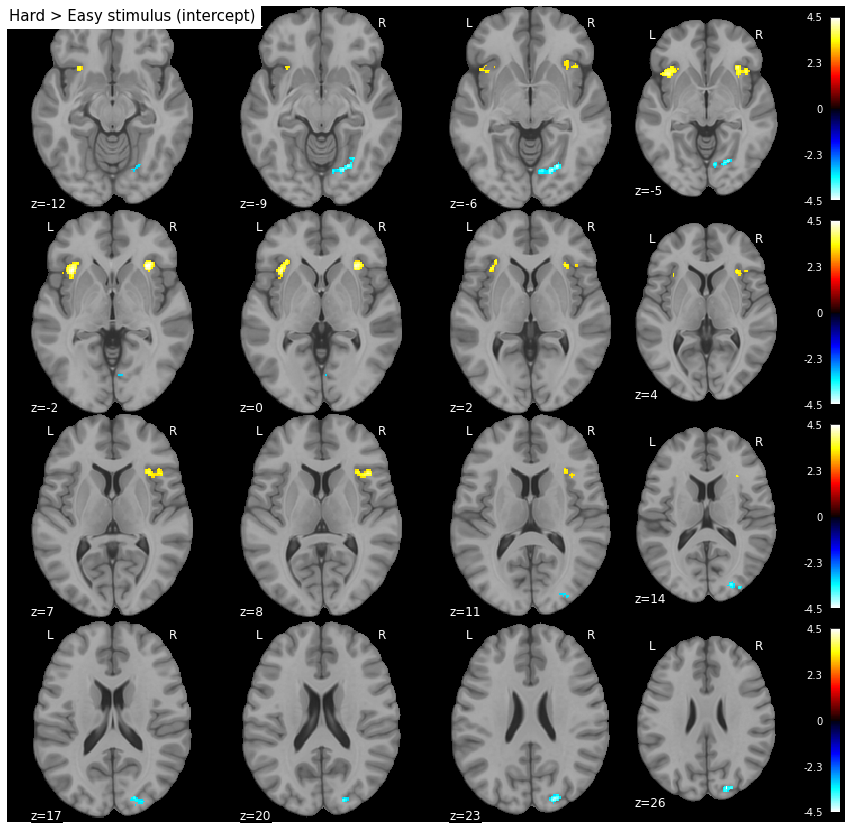

In [23]:
z_map_diff_intercept, threshold = get_second_level_zmap('stim_hard - stim_easy', 'intercept', 'fwer')
plot_4x4(z_map_diff_intercept, threshold=threshold, bg_img=mni09c, title='Hard > Easy stimulus (intercept)')

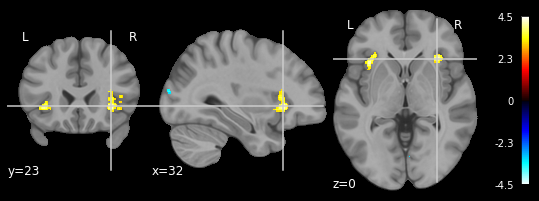

In [24]:
z_map_diff_intercept, threshold = get_second_level_zmap('stim_hard - stim_easy', 'intercept', 'fwer')
plotting.plot_stat_map(z_map_diff_intercept, bg_img=mni09c)

And the `v_shift` covariate?

(<Figure size 1080x1080 with 35 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

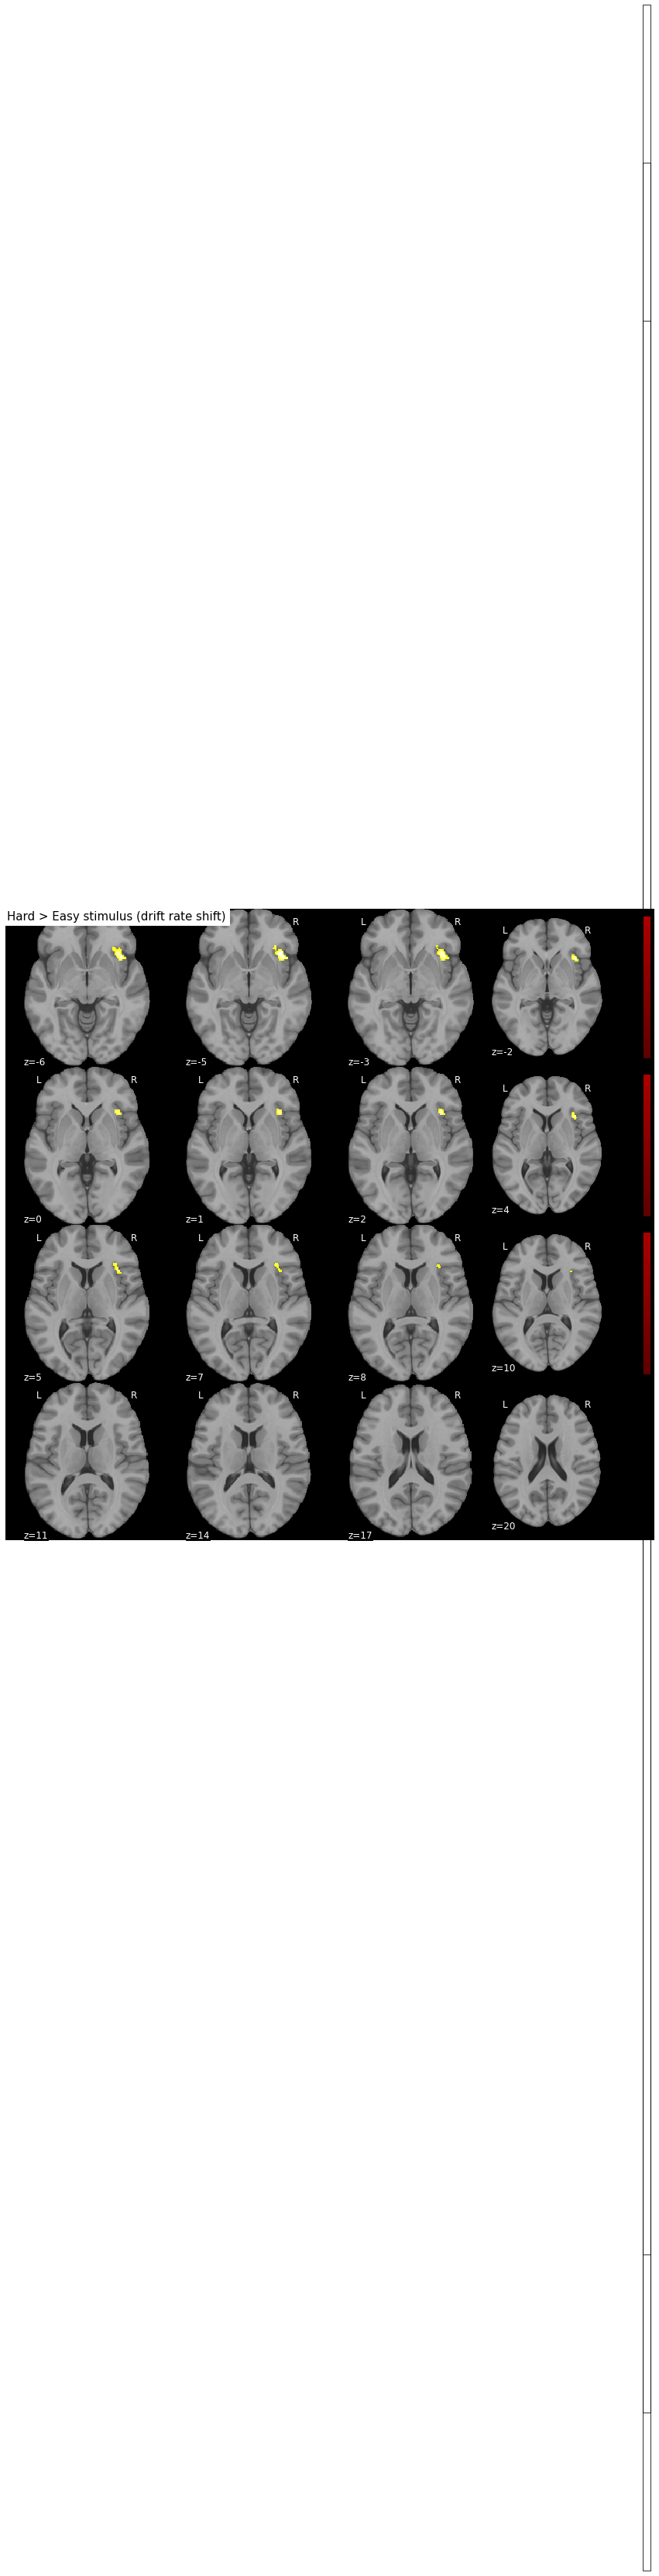

In [198]:
z_map_diff_vshift, threshold = get_second_level_zmap('stim_hard - stim_easy', 'v_shift', 'fwer')
plot_4x4(z_map_diff_vshift, threshold=threshold, bg_img=mni09c, title='Hard > Easy stimulus (drift rate shift)')

(<Figure size 1080x1080 with 35 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

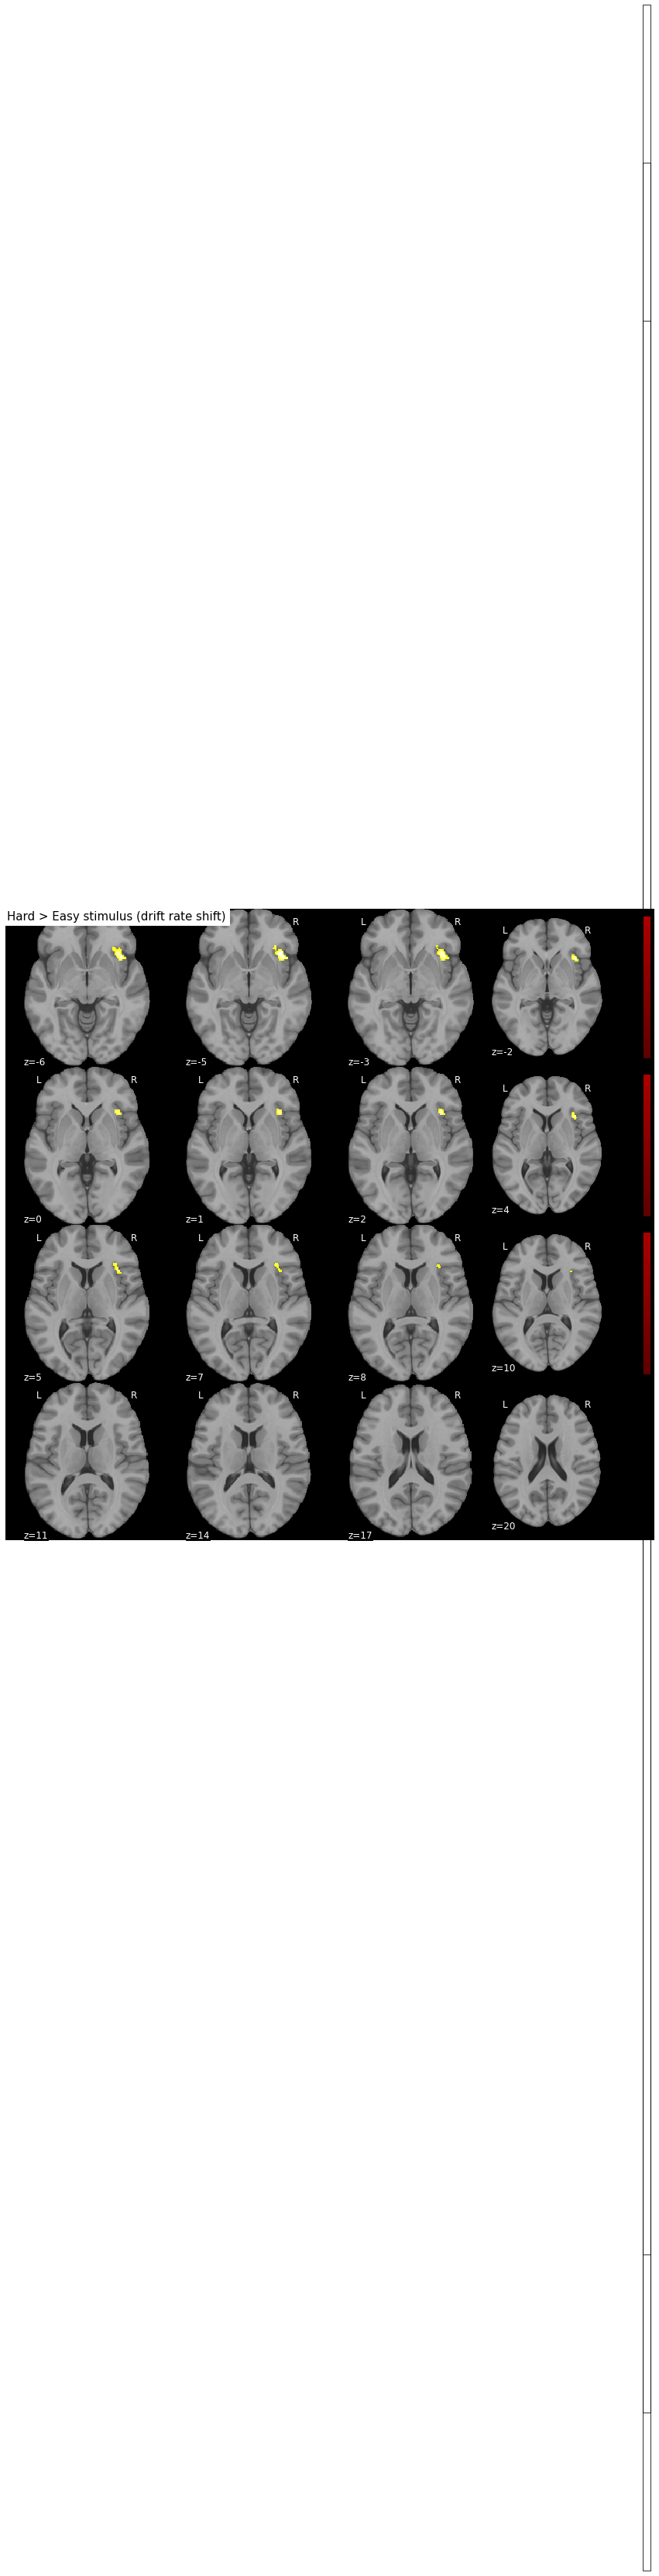

In [26]:
z_map_diff_vshift, threshold = get_second_level_zmap('stim_hard - stim_easy', 'v_shift', 'fwer')
plot_4x4(z_map_diff_vshift, threshold=threshold, bg_img=mni09c, title='Hard > Easy stimulus (drift rate shift)')

## Cue left - Cue right

Not in paper; we find a cluster in visual cortex for this contrast

(<Figure size 1080x1080 with 35 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

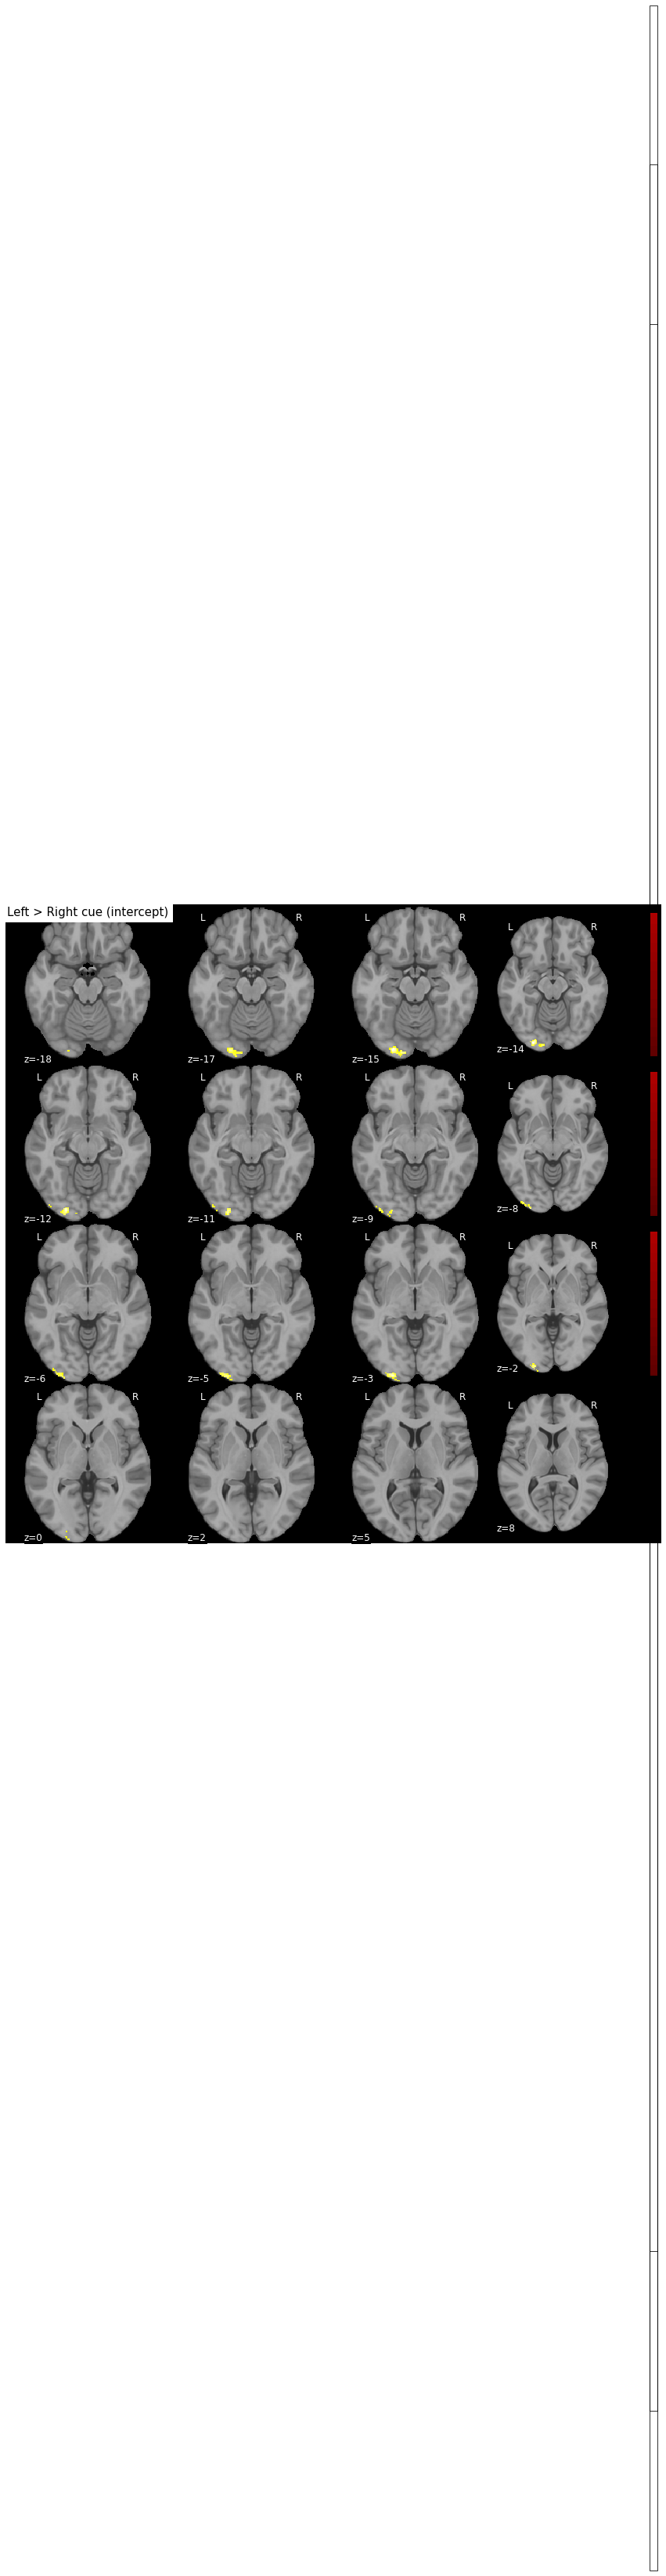

In [27]:
z_map_cuelr_intercept, threshold = get_second_level_zmap('cue_left - cue_right', 'intercept', 'fwer')
plot_4x4(z_map_cuelr_intercept, threshold=threshold, bg_img=mni09c, title='Left > Right cue (intercept)')

Nothing related to a starting point shift

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

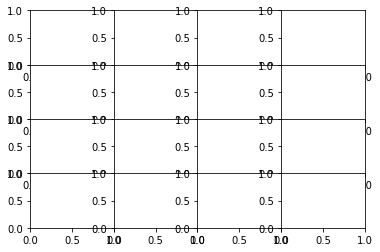

In [28]:
z_map_cuelr_zshift, threshold = get_second_level_zmap('cue_left - cue_right', 'z_shift', 'fwer')  # nothing
plot_4x4(z_map_cuelr_zshift, threshold=threshold, bg_img=mni09c, title='Left > Right cue (start point shift)')

## Figure for paper

In [29]:
from nilearn import plotting
def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%.1f", cmap=plotting.cm.cold_hot, tick_left=True, tick_right=False, is_symmetric=True):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    
    if nb_ticks > 0:
        ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    else:
        ticks = []
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    if is_symmetric:
        norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format)
    
    if flip:
        colorbar_ax.invert_yaxis()
    if tick_left:
        colorbar_ax.yaxis.tick_left()
    if tick_right:
        colorbar_ax.yaxis.tick_right()

    return colorbar_ax

In [30]:
z_map_responselr_intercept_fwer, threshold = get_second_level_zmap('response_left - response_right', 'intercept', 'fwer')
z_map_error_intercept_fwer, threshold = get_second_level_zmap('error', 'intercept', 'fwer')
z_map_cue_intercept_fwer, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'intercept', 'fwer')
z_map_diff_intercept, threshold = get_second_level_zmap('stim_hard - stim_easy', 'intercept', 'fwer')
z_map_diff_vshift, threshold = get_second_level_zmap('stim_hard - stim_easy', 'v_shift', 'fwer')

Text(0.5, 1.0, 'Difficulty (Hard > Easy)')

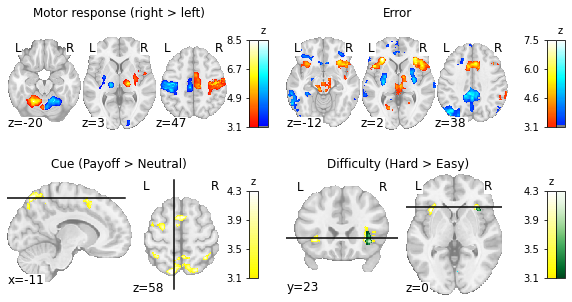

In [31]:
font = {'size'   : 10}
import matplotlib
matplotlib.rc('font', **font)
f = plt.figure(figsize=(10,5))
gridspec = f.add_gridspec(ncols=14, nrows=2, 
                          hspace=.25, wspace=0.0, 
                          width_ratios=np.array([[1]*6 + [1.5]*1] * 2).ravel().tolist())

# left/right
ax0 = f.add_subplot(gridspec[0,0:6])
plotting.plot_stat_map(z_map_responselr_intercept_fwer, display_mode='z', colorbar=False, vmax=8.5,# title='Motor responses (R > L)',
                       cut_coords=[-20, 3, 47], figure=f, axes=ax0, bg_img=mni09c, black_bg=False)  #, **kwargs)
# colorbar
gs00 = gridspec[0,6].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,1]), 
                                truncation_limits=(3.1, 8.5), vmax=8.5, offset=3.1, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,2]), 
                                truncation_limits=(-3.1,-8.5), 
                                vmax=8.5, offset=3.1, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)
#cbar_ax2.set_ticks([])
ax0.set_title('Motor response (right > left)')


# error
ax1 = f.add_subplot(gridspec[0,7:13])
plotting.plot_stat_map(z_map_error_intercept_fwer, display_mode='z', colorbar=False, vmax=7.5,
                       cut_coords=[-12, 2, 38], figure=f, axes=ax1, bg_img=mni09c, black_bg=False)
# colorbar
gs01 = gridspec[0,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 2, 1, 1], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,2]), truncation_limits=(3.1,7.5), vmax=7.5, offset=3.1, flip=False)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,3]), truncation_limits=(-3.1,-7.5), vmax=7.5, offset=3.1, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)
#cbar_ax2.set_ticks([])
ax1.set_title('Error')


# Cue
ax2 = f.add_subplot(gridspec[1,0:6])
plotting.plot_stat_map(z_map_cue_intercept_fwer, display_mode='xz', colorbar=False, vmax=4.3,
                       cut_coords=[-11, 58], figure=f, axes=ax2, bg_img=mni09c, black_bg=False)
gs10 = gridspec[1,6].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs10[1,1]), truncation_limits=(3.1,4.3), vmax=4.3, offset=3.1, flip=False)
cbar_ax1.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)
ax2.set_title('Cue (Payoff > Neutral)')


ax3 = f.add_subplot(gridspec[1,7:13])
disp = plotting.plot_stat_map(z_map_diff_intercept, display_mode='yz', colorbar=False,
                              cut_coords=[23, 0], figure=f, axes=ax3, bg_img=mni09c, vmax=4.3, black_bg=False)
disp.add_overlay(z_map_diff_vshift, cmap='Greens_r', vmax=4.3, vmin=3.1)
gs11 = gridspec[1,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 2, 1, 1], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,2]), truncation_limits=(3.1, 4.3), vmax=4.3, offset=3.1, flip=False)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,3]), 
                                vmin=0, truncation_limits=(0, 4.3), vmax=4.3, offset=0, flip=False, 
                                cmap=plt.get_cmap('Greens_r'), tick_left=False, nb_ticks=0, is_symmetric=False)
cbar_ax1.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)
#cbar_ax2.set_ticks([])
ax3.set_title('Difficulty (Hard > Easy)')

#f.tight_layout()
#f.set_size_inches(9,4)  ## approximately A4 width with 1-inch margin

In [77]:
f.savefig('figures/figure2.pdf', bbox_inches='tight')

## Supplementary figure

In [32]:
def threshold_(nii, min_val=2.3):
    dat = nii.get_data()
    dat[dat<min_val] = 0
    return nib.Nifti1Image(dat, nii.affine)

In [33]:
z_map_cue_vshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'v_shift_bias', None)
z_map_cue_vshift_thresh = threshold_(z_map_cue_vshift)
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'z_shift', None)
z_map_cue_zshift_thresh = threshold_(z_map_cue_zshift)
#plotting.plot_stat_map(z_map_cue_vshift, threshold=2.3, bg_img=mni09c)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


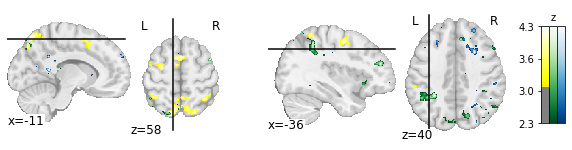

In [73]:
font = {'size'   : 10}
import matplotlib
matplotlib.rc('font', **font)
f = plt.figure(figsize=(10,2.5))
gridspec = f.add_gridspec(ncols=14, nrows=1, 
                          hspace=.25, wspace=0.0, 
                          width_ratios=np.array([[1]*12 + [1.5]*2]).ravel().tolist())
ax0 = f.add_subplot(gridspec[0,0:6])
ax1 = f.add_subplot(gridspec[0,7:13])

disp = plotting.plot_stat_map(z_map_cue_intercept_fwer, display_mode='xz', colorbar=False, vmax=4.3,
                              cut_coords=[-11, 58], bg_img=mni09c, figure=f, axes=ax0, black_bg=False)
disp.add_overlay(z_map_cue_vshift_thresh, cmap='Greens_r')
disp.add_overlay(z_map_cue_zshift_thresh, cmap='Blues_r')

disp = plotting.plot_stat_map(z_map_cue_intercept_fwer, display_mode='xz', colorbar=False, vmax=4.3,
                              cut_coords=[-36, 40], bg_img=mni09c, figure=f, axes=ax1, black_bg=False)
disp.add_overlay(z_map_cue_vshift_thresh, cmap='Greens_r')
disp.add_overlay(z_map_cue_zshift_thresh, cmap='Blues_r')

gs11 = gridspec[0,-1].subgridspec(3, 5, hspace=0, wspace=0, width_ratios=[2, 2, 1, 1, 1], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,2]), truncation_limits=(2.3, 4.3), 
                                vmax=4.3, offset=3.1, flip=False)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,3]), 
                                vmin=0, truncation_limits=(0, 4.3), vmax=4.3, offset=0, flip=False, 
                                cmap=plt.get_cmap('Greens_r'), tick_left=False, nb_ticks=0, is_symmetric=False)
cbar_ax3 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,4]), 
                                vmin=0, truncation_limits=(0, 4.3), vmax=4.3, offset=0, flip=False, 
                                cmap=plt.get_cmap('Blues_r'), tick_left=False, nb_ticks=0, is_symmetric=False)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')
f.savefig('figures/figure_supp.pdf', bbox_inches='tight')

let's have a look at the blue-ish cluster that appears for the start point shift covariate; where is it?

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


259

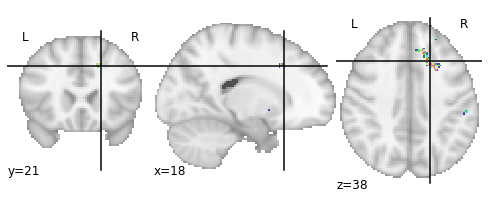

In [35]:
from nilearn.regions import RegionExtractor

# min_region_size in voxel volume mm^3
extraction = nilearn.regions.connected_regions(z_map_cue_zshift_thresh, min_region_size=10)
def get_cluster_size(nii):
    return (nii.get_data()>0).sum()

this_img = nilearn.image.index_img(extraction[0], 0)
plotting.plot_roi(this_img)
get_cluster_size(this_img)

In white matter...

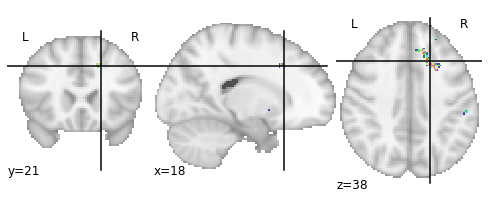

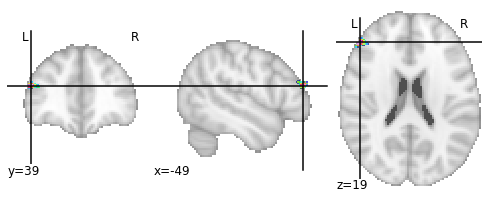

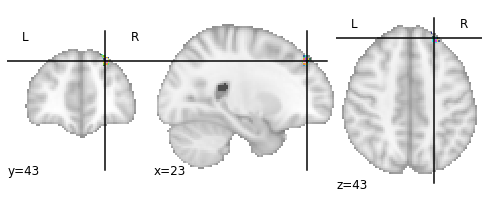

In [36]:
plotting.plot_roi(nilearn.image.index_img(extraction[0], 0))
plotting.plot_roi(nilearn.image.index_img(extraction[0], 4))
plotting.plot_roi(nilearn.image.index_img(extraction[0], 19))

Also the other clusters aren't convincing

## Supplementary tables with all clusters
Here, we use the H-O atlas as well as the Julich atlas to identify where we are. Note that the Harvard-Oxford atlas' "Lateral Occipital Cortex" extends well into the parietal lobe; the Julich atlas provides a less confusing label there.


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to ./tmp_registration_files/
skip computation (use existing results)


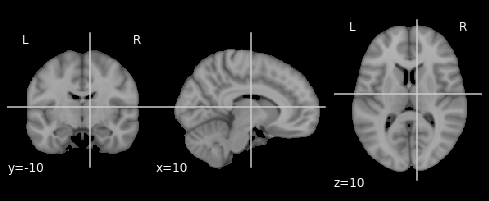

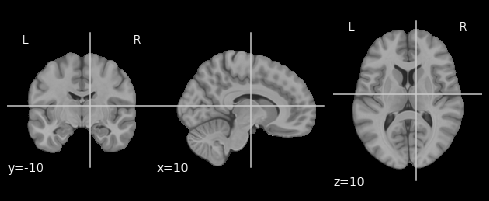

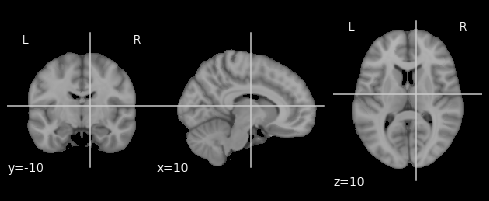

In [154]:
import nighres

# 1. Get the H-O atlas in mni09c-space
atlas_name = 'cort-maxprob-thr0-1mm'
atlas = nilearn.datasets.fetch_atlas_harvard_oxford(atlas_name)  # this is MNI05

# To get the locations, warp the harvard-oxford atlas to MNI09c
mni05_template = '/usr/local/fsl/6.0/data/standard/MNI152_T1_1mm_brain.nii.gz'
mni09c_template = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# some tmp filenames for nighres
source_fn_tmp = './tmp_registration_files/mni05_source.nii.gz'
target_fn_tmp = './tmp_registration_files/mni09c_target.nii.gz'
nib.load(mni05_template).to_filename(source_fn_tmp)
nib.load(mni09c_template).to_filename(target_fn_tmp)

# get warp
registration = nighres.registration.embedded_antsreg(source_image=source_fn_tmp, target_image=target_fn_tmp,
                                                     run_rigid=True, run_syn=True,
                                                     save_data=True, output_dir='./tmp_registration_files')

plotting.plot_anat(mni05_template, cut_coords=[10,-10,10])
plotting.plot_anat(mni09c_template, cut_coords=[10,-10,10])
plotting.plot_anat(registration['transformed_sources'][0], cut_coords=[10,-10,10])

In [155]:
## Apply warp to HO atlas
atlas_name = 'cort-maxprob-thr0-1mm'
atlas = nilearn.datasets.fetch_atlas_harvard_oxford(atlas_name)
atlas_maps_mni09c = nighres.registration.apply_coordinate_mappings(atlas.maps, mapping1=registration['mapping'])
atlas.maps_mni09c = atlas_maps_mni09c['result']


Apply coordinate mappings


In [101]:
## get the transform that warps (upscales) the statistical parametric maps from 1p5mm to 1mm
# since we're not actually applying a 'transfomration', we just need the final data shape & affine
example_nii_mni1mm = nib.load('./derivatives/ds-01/fmriprep/sub-01/anat/sub-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
tmp_target_fn = './tmp_registration_files/target.nii.gz'
example_nii_mni1mm.to_filename(tmp_target_fn)

tmp_source_fn = './tmp_registration_files/tmp_source.nii.gz'
nib.load(zmap).to_filename(tmp_source_fn)
output = nighres.registration.embedded_antsreg(source_image=tmp_source_fn, target_image=tmp_target_fn, 
                                               run_rigid=False, run_affine=False, run_syn=False, save_data=True,
                                               output_dir='./tmp_registration_files')
this_img_mni1mm = output['transformed_sources'][0]
mapping = output['mapping']


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to ./tmp_registration_files/

Saving ./tmp_registration_files/tmp_source_tmp_srccoord.nii.gz

Saving ./tmp_registration_files/tmp_source_tmp_trgcoord.nii.gz
registering ./tmp_registration_files/tmp_source.nii.gz
 to ./tmp_registration_files/target.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output tmp_source_tmp_syn --transform Rigid[0.1] --metric CC[./tmp_registration_files/target.nii.gz, ./tmp_registration_files/tmp_source.nii.gz, 1.000, 5, Random, 0.3 ] --convergence [ 0x0x0, 1.0, 2 ] --smoothing-sigmas 3.0x2.0x1.0 --shrink-factors 4x2x1 --use-histogram-matching 0 --winsorize-image-intensities [ 0.001, 0.999 ] --write-composite-transform 0 --verbose 1
antsApplyTransforms --dimensionality 3 --input-image-type 0 --input ./tmp_registration_files/tmp_source.nii.gz --reference-image ./tmp_registration_files/target.nii.gz --interpola

In [157]:
# Extract clusters: Peak location (MNI09c 1mm and matrix indices), peak value, Harvard-Oxford atlas label

response_left - response_right intercept

Apply coordinate mappings


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  



Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings
response_left - response_right -intercept

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings
error intercept

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/plotting/displays.py:602: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)



Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings
error -intercept

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings
cue_payoff - cue_neutral intercept

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings
cue_payoff - cue_neutral -intercept

Apply coordinate mappings
stim_hard - stim_easy intercept

Apply coordinate mappings

Apply coordinate mappings
stim_hard - stim_easy -intercept

Apply coordinate mappings

Apply coordinate mappings
stim_hard 

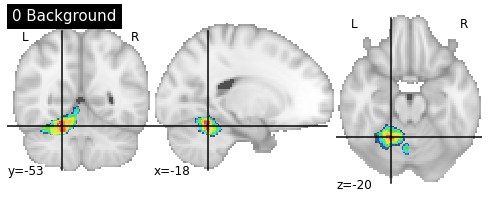

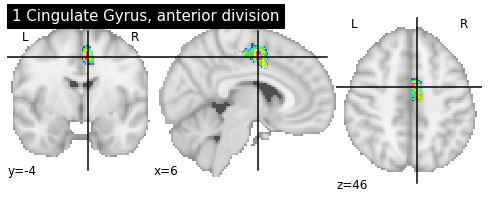

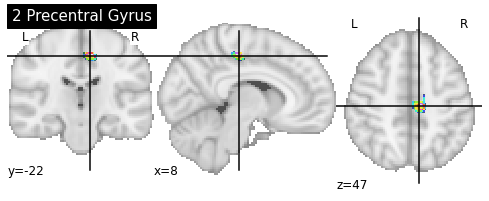

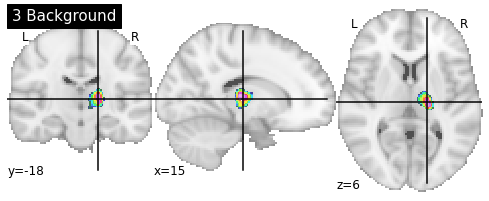

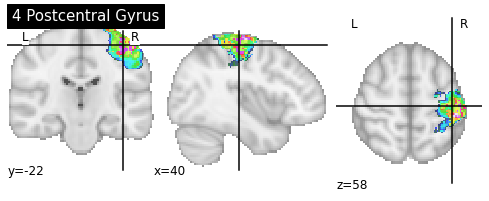

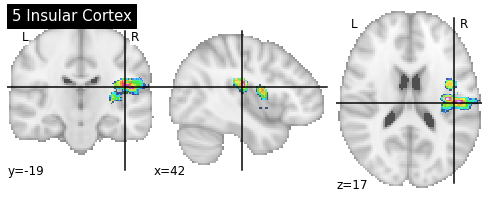

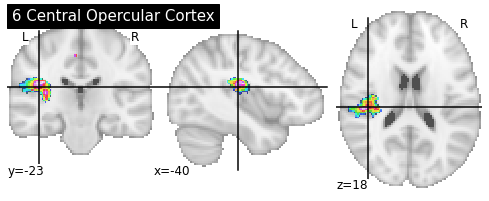

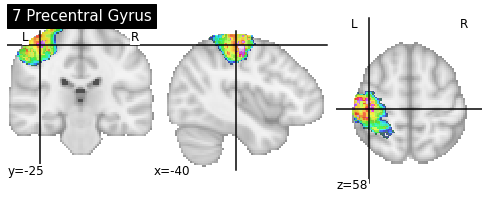

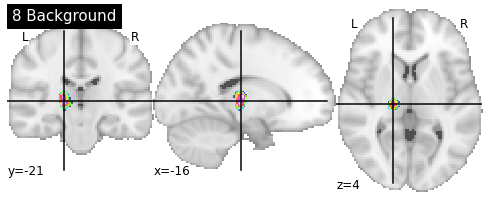

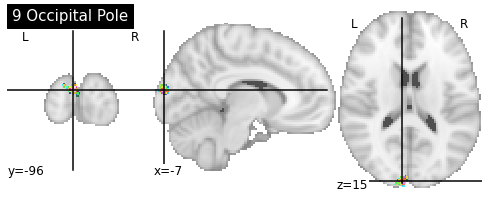

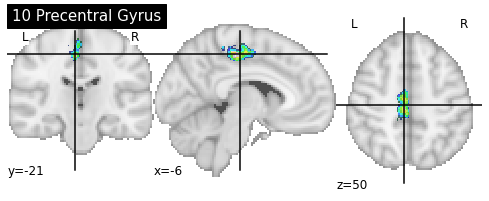

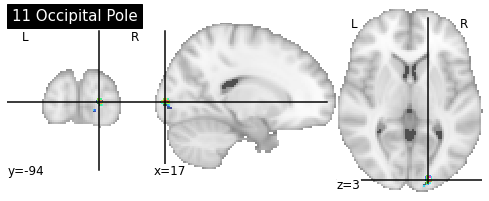

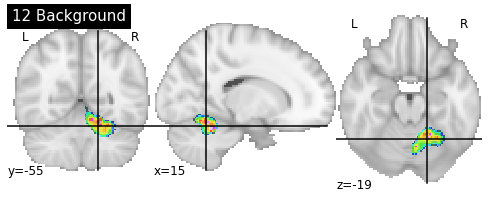

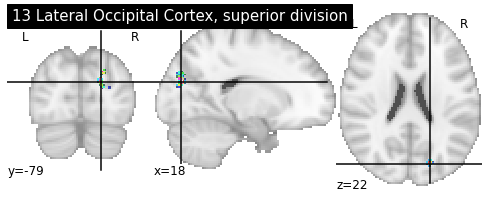

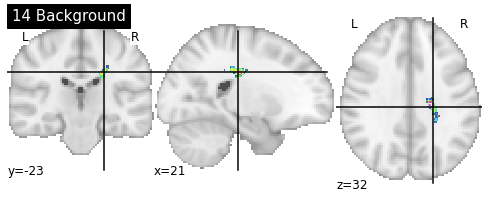

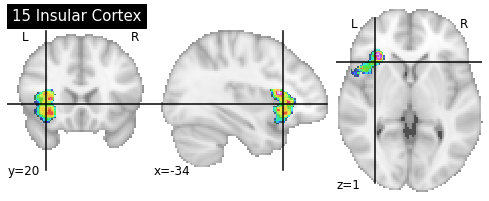

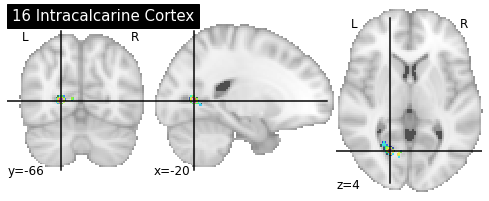

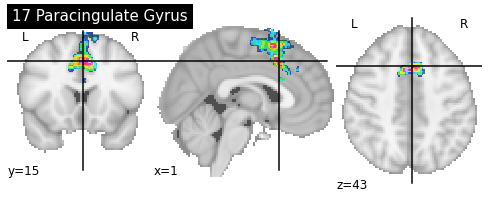

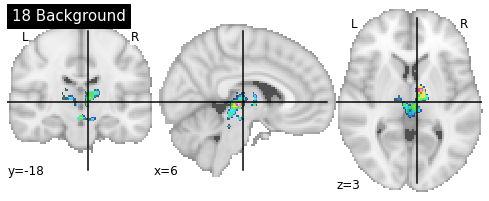

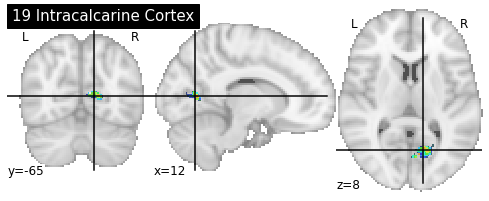

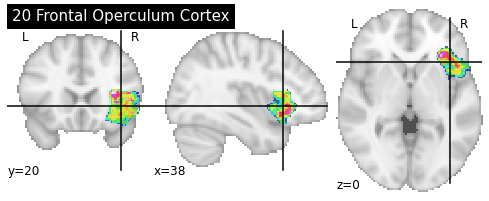

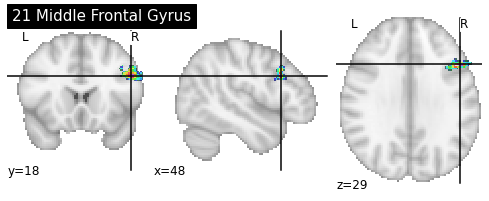

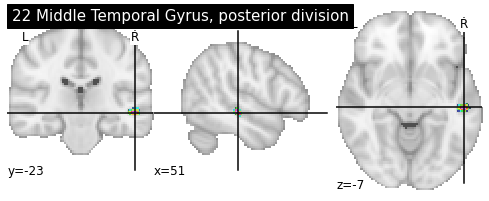

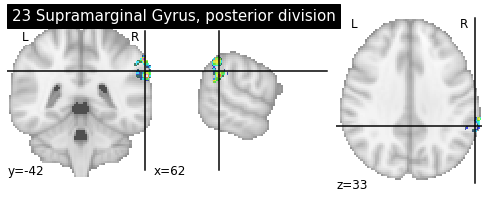

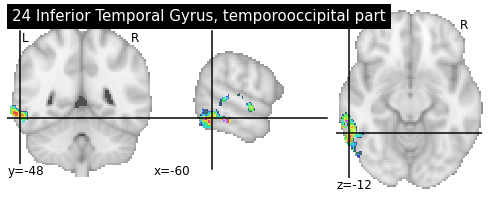

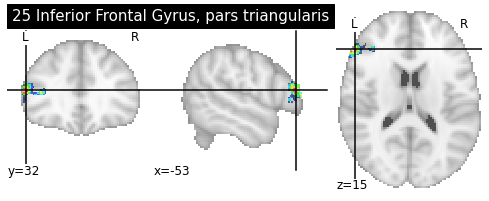

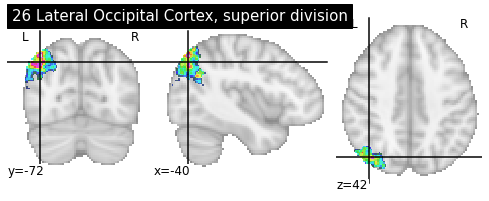

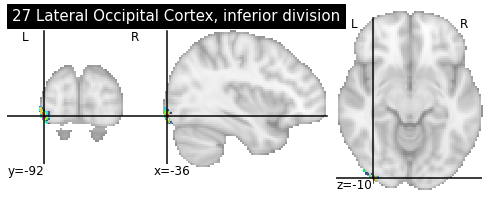

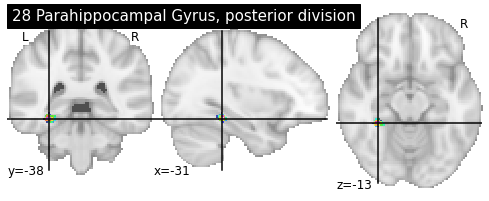

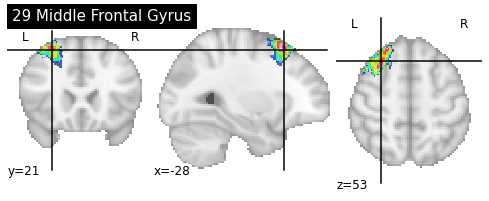

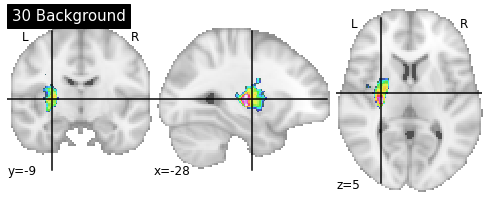

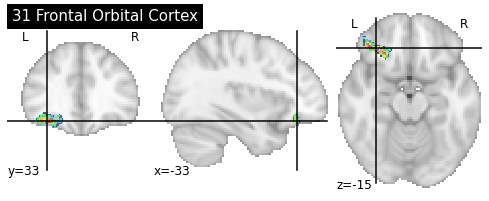

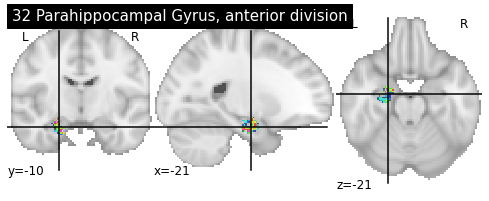

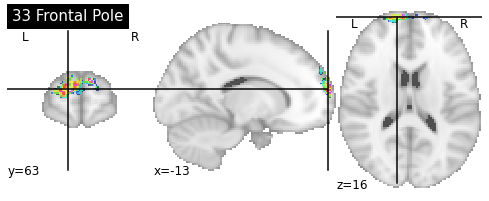

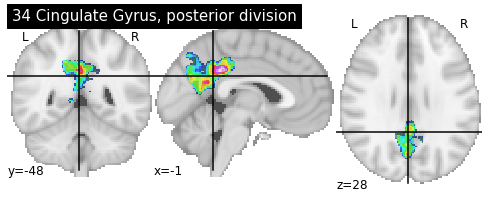

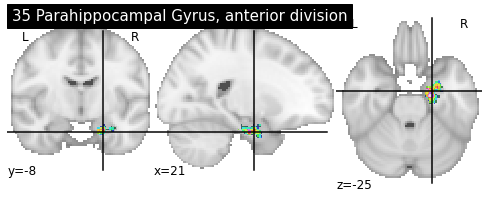

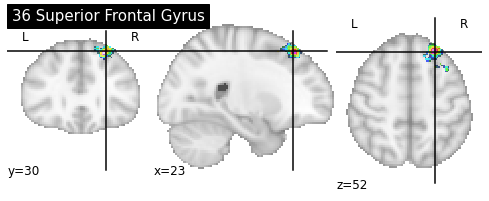

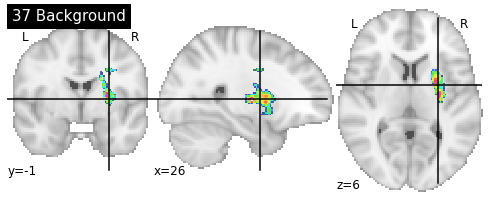

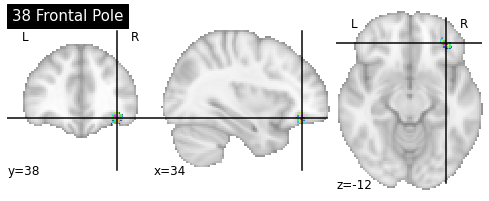

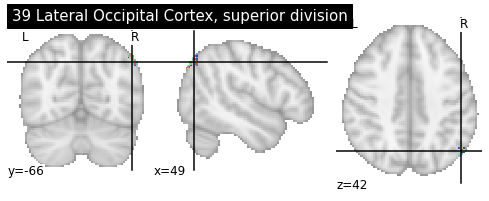

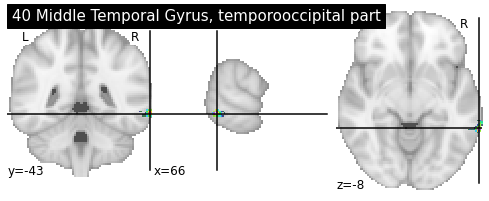

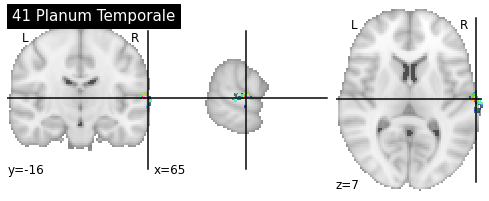

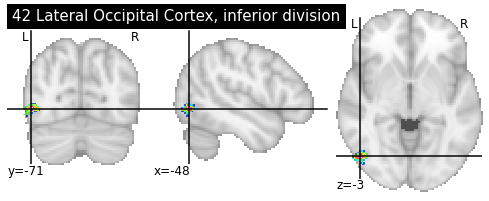

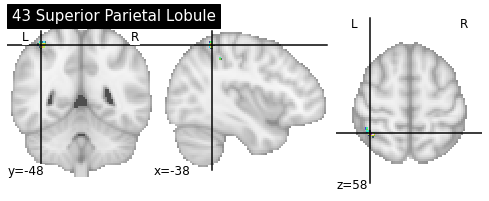

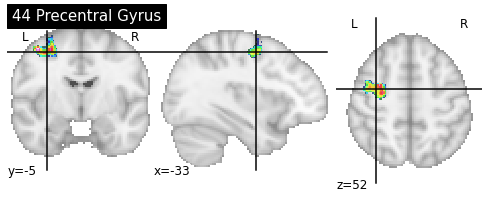

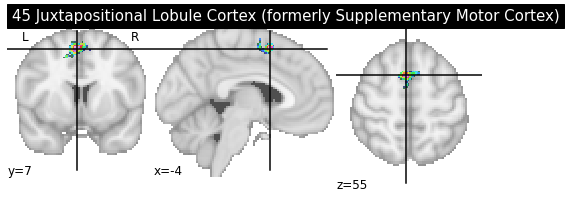

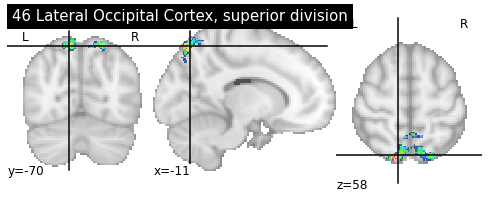

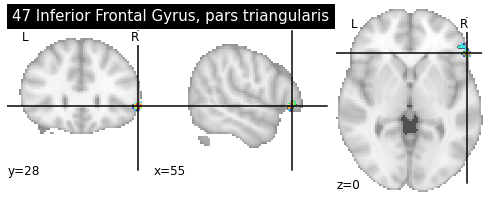

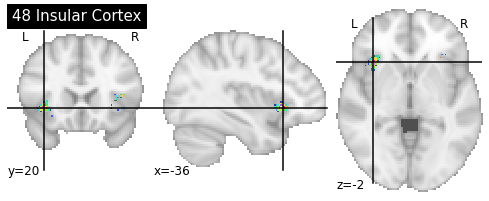

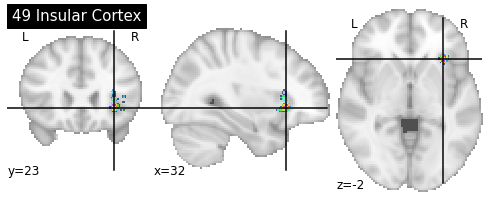

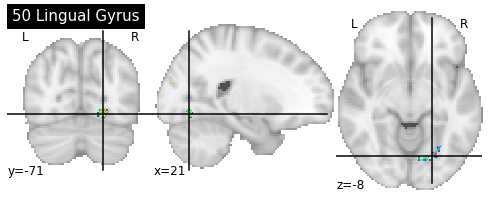

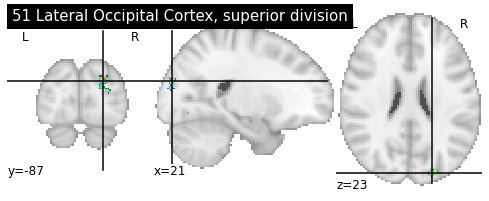

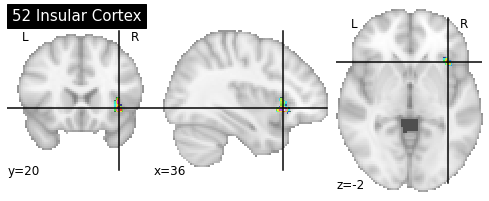

In [192]:
def get_peak_location(nii, apply_affine=True):
    # find voxel with maximum value
    data = nii.get_fdata()
    peak = np.where(data==data.max())
    coords_index = np.array([peak[0][0], peak[1][0], peak[2][0]])
    
    # apply the affine?
    if apply_affine:
        coords_mni = nilearn.image.resampling.coord_transform(coords_index[0], coords_index[1], coords_index[2], nii.affine)
        return coords_mni
    else:
        return coords_index

def get_ho_max_prob_label(x,y,z, atlas=atlas):
    return atlas.labels[int(atlas.maps_mni09c.get_fdata()[int(x),int(y),int(z)])]

    
all_clusters = []
cluster_n = 0
for contrast in ['response_left - response_right',
                 'error',
                 'cue_payoff - cue_neutral',
                 'stim_hard - stim_easy']:
    second_levels = ['intercept', '-intercept']
    if contrast == 'stim_hard - stim_easy':
        second_levels += ['v_shift']
    
    for second_level in second_levels:
        zmap, threshold = get_second_level_zmap(contrast, second_level, thresholding='fwer1')
        print('{} {}'.format(contrast, second_level))

        extraction = nilearn.regions.connected_regions(zmap, min_region_size=10)
        for i in range(extraction[0].shape[-1]):
            this_img = nilearn.image.index_img(extraction[0], i)
            # upscale to 1mm resolution to get the coordinates in "H-O" space
            tmp_source_fn = './tmp_registration_files/tmp{}.nii.gz'.format(cluster_n)
            this_img.to_filename(tmp_source_fn)
            output = nighres.registration.apply_coordinate_mappings(tmp_source_fn,
                                                                    mapping1=mapping)
            this_img_mni1mm = output['result']

            peak_mni = get_peak_location(this_img_mni1mm)
            peak_index = get_peak_location(this_img_mni1mm, False)
            label = get_ho_max_prob_label(peak_index[0], peak_index[1], peak_index[2])
            plotting.plot_roi(this_img, title='{} {}'.format(cluster_n, label))
            all_clusters.append(pd.DataFrame({'n_voxels': get_cluster_size(this_img),
                                              'peakx_mni': peak_mni[0],
                                              'peaky_mni': peak_mni[1],
                                              'peakz_mni': peak_mni[2],
                                              'peakx_index': peak_index[0],
                                              'peaky_index': peak_index[1],
                                              'peakz_index': peak_index[2],
                                              'zmax': this_img.get_fdata().max(),
                                              'HO_label': label,
                                              'firstlevel': contrast,
                                              'secondlevel': second_level}, index=[cluster_n]))
            cluster_n += 1

In [180]:
# Ok, so these are clean enough
all_clusters_df = pd.concat(all_clusters)

In [181]:
all_clusters_df['volume'] = all_clusters_df['n_voxels']*(1.5**3)
all_clusters_df.loc[all_clusters_df['secondlevel'].apply(lambda x: x[0])=='-', 'zmax'] = -all_clusters_df.loc[all_clusters_df['secondlevel'].apply(lambda x: x[0])=='-', 'zmax']

In [182]:
all_clusters_df[['firstlevel', 'secondlevel', 'HO_label', 'peakx_mni', 'peaky_mni', 'peakz_mni', 'volume', 'zmax']].sort_values(['firstlevel', 'volume'], ascending=[True, False])

firstlevel secondlevel  \
46        cue_payoff - cue_neutral   intercept   
44        cue_payoff - cue_neutral   intercept   
45        cue_payoff - cue_neutral   intercept   
42        cue_payoff - cue_neutral   intercept   
43        cue_payoff - cue_neutral   intercept   
47        cue_payoff - cue_neutral  -intercept   
34                           error  -intercept   
17                           error   intercept   
20                           error   intercept   
26                           error  -intercept   
15                           error   intercept   
24                           error  -intercept   
18                           error   intercept   
29                           error  -intercept   
30                           error  -intercept   
37                           error  -intercept   
33                           error  -intercept   
36                           error  -intercept   
31                           error  -intercept   
23                           error   intercept   
25                           error  -intercept   
21                           error   intercept   
32                           error  -intercept   
35                           error  -intercept   
16                           error   intercept   
41                           error  -intercept   
19                           error   intercept   
27                           error  -intercept   
40                           error  -intercept   
38                           error  -intercept   
22                           error   intercept   
28                           error  -intercept   
39                           error  -intercept   
7   response_left - response_right  -intercept   
4   response_left - response_right   intercept   
5   response_left - response_right   intercept   
0   response_left - response_right   intercept   
12  response_left - response_right  -intercept   
6   response_left - response_right  -intercept   
1   response_left - response_right   intercept   
10  response_left - response_right  -intercept   
3   response_left - response_right   intercept   
8   response_left - response_right  -intercept   
14  response_left - response_right  -intercept   
13  response_left - response_right  -intercept   
9   response_left - response_right  -intercept   
2   response_left - response_right   intercept   
11  response_left - response_right  -intercept   
48           stim_hard - stim_easy   intercept   
52           stim_hard - stim_easy     v_shift   
49           stim_hard - stim_easy   intercept   
50           stim_hard - stim_easy  -intercept   
51           stim_hard - stim_easy  -intercept   

                                             HO_label  peakx_mni  peaky_mni  \
46        Lateral Occipital Cortex, superior division      -16.0      -76.0   
44                                   Precentral Gyrus      -43.0       -5.0   
45  Juxtapositional Lobule Cortex (formerly Supple...       -5.0        8.0   
42        Lateral Occipital Cortex, inferior division      -50.0      -73.0   
43                           Superior Parietal Lobule      -37.0      -50.0   
47          Inferior Frontal Gyrus, pars triangularis       56.0       28.0   
34                Cingulate Gyrus, posterior division        1.0      -41.0   
17                                Paracingulate Gyrus       11.0       23.0   
20                           Frontal Operculum Cortex       32.0       17.0   
26        Lateral Occipital Cortex, superior division      -40.0      -73.0   
15                                     Insular Cortex      -32.0       28.0   
24     Inferior Temporal Gyrus, temporooccipital part      -53.0      -55.0   
18                                         Background       -8.0      -29.0   
29                               Middle Frontal Gyrus      -34.0       16.0   
30                                         Background      -31.0      -16.0   
37                                         Background      

Select only the relevant columns, sort by contrast & size, and save to disk for manual editing & refinements

In [191]:
all_clusters_2 = {}
for firstlevel in all_clusters.firstlevel.unique():
    all_clusters_2[firstlevel] = all_clusters.loc[all_clusters['firstlevel'] == firstlevel].sort_values('volume', ascending=False)
pd.concat([all_clusters_2['response_left - response_right'],
           all_clusters_2['error'],
           all_clusters_2['cue_payoff - cue_neutral'],
           all_clusters_2['stim_hard - stim_easy']])[['firstlevel', 'secondlevel', 'HO_label', 'peakx_mni', 'peaky_mni', 'peakz_mni', 'volume', 'zmax']].to_csv('./supplementary_table.csv')